In [5]:
import os
import pickle

import hmmlearn.hmm as hmm
import numpy as np
import seaborn as sn
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import preprocessing

In [6]:
class HMMTraining:
    def __init__(self):
        self.class_names = ['batden', 'tatden', 'batquat','tatquat','mocua','dongcua','batdieuhoa','tatdieuhoa','tangtocdoquat','giamtocdoquat']
        self.states = []
        self.dataset_path = 'datasets'

        self.X = {'train': {}, 'validate': {},'test': {}}
        self.y = {'train': {}, 'validate': {},'test': {}}

        self.model = {}
        self.model_path = 'models_train'
    def split_data(self):
        length = 0
        for cn in self.class_names:
            length += len(os.listdir(f"{self.dataset_path}/{cn}"))
        print('Total samples:', length)

        all_data = {}
        all_labels = {}
        for cname in self.class_names:
            file_paths = [os.path.join(self.dataset_path, cname, i) for i in os.listdir(
                os.path.join(self.dataset_path, cname)) if i.endswith('.wav')]
            data = [preprocessing.get_mfcc(file_path) for file_path in file_paths]
            all_data[cname] = data
            all_labels[cname] = [self.class_names.index(cname) for _ in range(len(file_paths))]

        for cname in self.class_names:
            x_train, x_remain, y_train, y_remain = train_test_split(
                all_data[cname], all_labels[cname],
                test_size=0.4,
                random_state=10
            )
            x_validate, x_test, y_validate, y_test = train_test_split(
                x_remain, y_remain,
                test_size=0.5,
                random_state=10
            )
            self.X['train'][cname] = x_train
            self.X['validate'][cname] = x_validate
            self.X['test'][cname] = x_test
            self.y['train'][cname] = y_train
            self.y['validate'][cname] = y_validate
            self.y['test'][cname] = y_test
    def train(self,states_,n_mix):
        self.states = states_
        total_train = 0
        total_validate = 0
        total_test = 0
        for cname in self.class_names:
            train_count = len(self.X['train'][cname])
            validate_count = len(self.X['validate'][cname])
            test_count = len(self.X['test'][cname])
            print(cname, 'train:', train_count, '| validate:', validate_count, '| test:', test_count)
            total_train += train_count
            total_validate += validate_count
            total_test += test_count
        print('train samples:', total_train)
        print('validate samples:',total_validate)
        print('test samples:', total_test)

        for idx, cname in enumerate(self.class_names):
            start_prob = np.full(self.states[idx], 0.0)
            start_prob[0] = 1.0
            trans_matrix = np.full((self.states[idx], self.states[idx]), 0.0)
            p = 0.5
            np.fill_diagonal(trans_matrix, p)
            np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
            trans_matrix[-1, -1] = 1.0

            # trans matrix
            print(cname)
            print(trans_matrix)

            self.model[cname] = hmm.GMMHMM(
                n_components=self.states[idx],
                n_mix = n_mix,
                verbose=True,
                n_iter=300,
                startprob_prior=start_prob,
                transmat_prior=trans_matrix,
                params='stmc',
                init_params='mc',
                random_state=42
            )
            self.model[cname].fit(X=np.vstack(self.X['train'][cname]),
                                  lengths=[x.shape[0] for x in self.X['train'][cname]])
    def save_model(self):
        for cname in self.class_names:
            name = f'{self.model_path}/model_{cname}.pkl'
            with open(name, 'wb') as file:
                pickle.dump(self.model[cname], file)

    def evaluation(self,phase):
        print('====== Evaluation ======')
        print('Phase:', phase)
        predmean = []
        y_true = []
        y_pred = []
        for cname in self.class_names:
            y_true2 = []
            y_pred2 = []
            for mfcc, target in zip(self.X[phase][cname], self.y[phase][cname]):
                scores = [self.model[cname].score(mfcc) for cname in self.class_names]
                pred = np.argmax(scores)
                y_pred.append(pred)
                y_true.append(target)
                y_pred2.append(pred)
                y_true2.append(target)
            print(f'{cname}:', (np.array(y_true2) == np.array(y_pred2)).sum() / len(y_true2))
            predmean.append((np.array(y_true2) == np.array(y_pred2)).sum() / len(y_true2))
        print('Mean accuracy:', np.array(predmean).mean())
        print('======')
        print('Confusion matrix:')
        conf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(conf_matrix, index = [cname for cname in self.class_names],
                  columns = [cname for cname in self.class_names])
        sn.heatmap(df_cm, annot=True)
        plt.show()
        # print(confusion_matrix(y_true, y_pred))
plt.show()
        

In [7]:
hmm_train = HMMTraining()

Total samples: 1000
batden train: 60 | validate: 20 | test: 20
tatden train: 60 | validate: 20 | test: 20
batquat train: 60 | validate: 20 | test: 20
tatquat train: 60 | validate: 20 | test: 20
mocua train: 60 | validate: 20 | test: 20
dongcua train: 60 | validate: 20 | test: 20
batdieuhoa train: 60 | validate: 20 | test: 20
tatdieuhoa train: 60 | validate: 20 | test: 20
tangtocdoquat train: 60 | validate: 20 | test: 20
giamtocdoquat train: 60 | validate: 20 | test: 20
train samples: 600
validate samples: 200
test samples: 200
batden
[[0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

tatden
[[0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

batquat
[[0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

tatquat
[[0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

mocua
[[0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

dongcua
[[0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

batdieuhoa
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

tatdieuhoa
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

tangtocdoquat
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

giamtocdoquat
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

====== Evaluation ======
Phase: validate
batden: 1.0
tatden: 1.0
batquat: 1.0
tatquat: 0.9
mocua: 0.95
dongcua: 1.0
batdieuhoa: 1.0
tatdieuhoa: 1.0
tangtocdoquat: 1.0
giamtocdoquat: 1.0
Mean accuracy: 0.985
Confusion matrix:


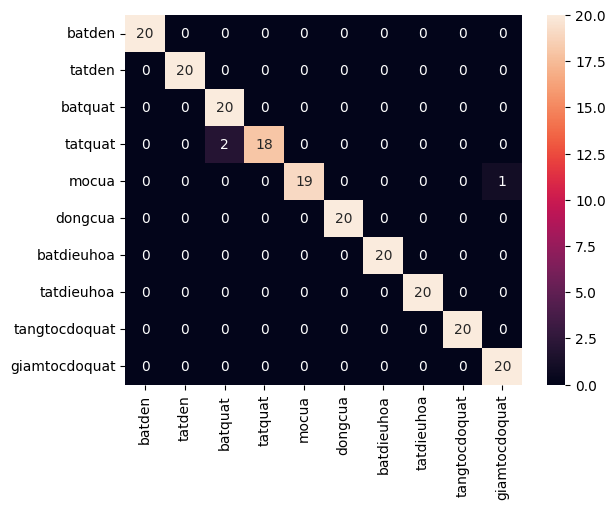

In [8]:
#Parameter Tuning
hmm_train.split_data()
hmm_train.train([8, 8, 8, 8, 7, 8, 10, 10, 14, 15],3)
#hmm_train.train([2, 2, 2, 2, 2, 2, 3, 3, 4, 4],5)
hmm_train.evaluation('validate')

====== Evaluation ======
Phase: test
batden: 1.0
tatden: 1.0
batquat: 1.0
tatquat: 0.9
mocua: 1.0
dongcua: 1.0
batdieuhoa: 1.0
tatdieuhoa: 0.95
tangtocdoquat: 0.9
giamtocdoquat: 1.0
Mean accuracy: 0.975
Confusion matrix:


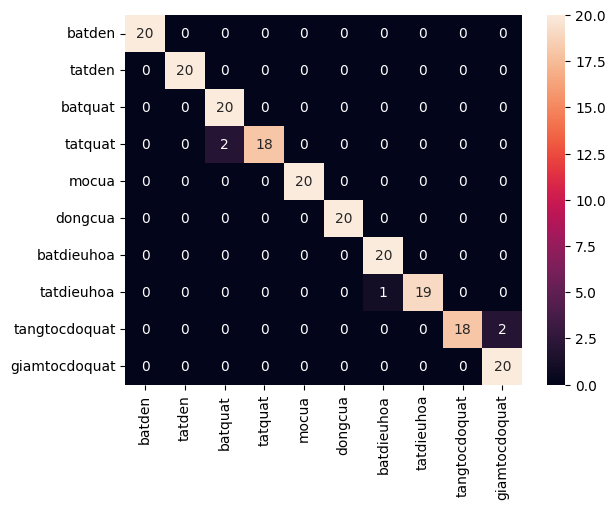

In [9]:
#Result
hmm_train.evaluation('test')

In [10]:
hmm_train.save_model()